In [ ]:
pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from tensorflow.keras.optimizers import RMSprop
import keras_tuner as kt

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d dhenyd/chili-plant-disease

Dataset URL: https://www.kaggle.com/datasets/dhenyd/chili-plant-disease
License(s): unknown
chili-plant-disease.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile

with zipfile.ZipFile('chili-plant-disease.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/chili-plant-disease')

In [ ]:
train_dir = '/content/chili-plant-disease/train'
val_dir = '/content/chili-plant-disease/val'
test_dir = '/content/chili-plant-disease/test'

In [ ]:
train_gen = ImageDataGenerator(
    rescale=1./255,
)
val_test_gen = ImageDataGenerator(
    rescale=1./255
    )

In [ ]:
train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    class_mode='categorical',
    shuffle=True
)

val_data = val_test_gen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    class_mode='categorical',
    shuffle=True
)

test_data = val_test_gen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    class_mode='categorical',
    shuffle=False
)

Found 400 images belonging to 5 classes.
Found 50 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


In [ ]:
classes = train_data.classes
print(classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


In [ ]:
base_model = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')

In [ ]:
base_model.summary()
base_model.trainable = False

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_17[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [ ]:
checkpoint_filepath = '/content/mobilenet_checkpoint.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, save_weights_only=True,
    monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

checkpoint_hyperparams_filepath = '/content/checkpoint/mobilenet_hyperparams_checkpoint.h5'
model_hyperparams_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_hyperparams_filepath,save_weights_only=True,
    monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, verbose=1, mode='max', restore_best_weights=True)

In [ ]:
def build_model(hp):
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    base_model.trainable = False

    num_dense_layers = hp.Choice('n_dense_layers', [2, 4, 6, 8, 10, 12, 14, 16])
    num_units = hp.Choice('units', [8, 16, 32, 64, 128])
    dropout_rate = hp.Choice('dropout_rate', [0.2, 0.3, 0.4, 0.5])
    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9])

    model = tf.keras.Sequential([
        base_model
    ])

    # Add Global Average Pooling layer
    if hp.Boolean('use_global_avg_pooling'):
        model.add(tf.keras.layers.GlobalAveragePooling2D())
    else:
        model.add(tf.keras.layers.Flatten())

    # Add Dense layer
    for i in range(num_dense_layers):
      model.add(tf.keras.layers.Dense(units=num_units, activation='relu'))

    # Add Dropout layers
    if hp.Boolean('use_dropout'):
      model.add(tf.keras.layers.Dropout(dropout_rate))

    model.add(tf.keras.layers.Dense(5, activation='softmax'))

    model.compile(loss = 'categorical_crossentropy', optimizer=RMSprop(learning_rate=learning_rate), metrics=['accuracy'])

    return model

In [ ]:
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=20,
    project_name='MobileNetV2HPSearch'
)

Reloading Tuner from ./MobileNetV2HPSearch/tuner0.json


In [ ]:
tuner.search(train_data,
             epochs=50,
             validation_data=val_data,
             batch_size = 32, callbacks=[model_hyperparams_checkpoint, early_stopping])

In [ ]:
best_hyperparams = tuner.get_best_hyperparameters()[0]
print(f"Best Hyper Parameters found are: {best_hyperparams.values}\n")

Best Hyper Parameters found are: {'n_dense_layers': 2, 'units': 16, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'use_global_avg_pooling': True, 'use_dropout': True}



In [ ]:
#Build the best model
model = build_model(best_hyperparams)
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_8  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_41 (Dense)            (None, 16)                20496     
                                                                 
 dense_42 (Dense)            (None, 16)                272       
                                                                 
 dropout_9 (Dropout)         (None, 16)                0         
                                                                 
 dense_43 (Dense)            (None, 5)                

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer=RMSprop(learning_rate=0.01), metrics=['accuracy'])

In [ ]:
history_tune = model.fit(
    train_data, epochs=500,
    batch_size=32, validation_data=val_data, callbacks=[model_hyperparams_checkpoint, early_stopping])

Epoch 1/500
13/13 [==============================] - ETA: 0s - loss: 2.4335 - accuracy: 0.2850
Epoch 1: val_accuracy improved from -inf to 0.44000, saving model to /content/checkpoint/mobilenet_hyperparams_checkpoint.h5
13/13 [==============================] - 5s 189ms/step - loss: 2.4335 - accuracy: 0.2850 - val_loss: 1.4045 - val_accuracy: 0.4400
Epoch 2/500
12/13 [==========================>...] - ETA: 0s - loss: 1.3897 - accuracy: 0.4620
Epoch 2: val_accuracy did not improve from 0.44000
13/13 [==============================] - 1s 61ms/step - loss: 1.3832 - accuracy: 0.4725 - val_loss: 1.5092 - val_accuracy: 0.3600
Epoch 3/500
12/13 [==========================>...] - ETA: 0s - loss: 1.1897 - accuracy: 0.4864
Epoch 3: val_accuracy did not improve from 0.44000
13/13 [==============================] - 1s 63ms/step - loss: 1.2501 - accuracy: 0.4700 - val_loss: 1.8542 - val_accuracy: 0.3000
Epoch 4/500
12/13 [==========================>...] - ETA: 0s - loss: 1.1443 - accuracy: 0.5462
Ep

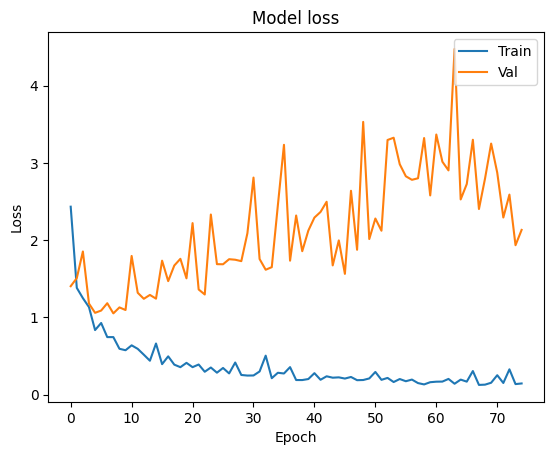

In [ ]:
plt.plot(history_tune.history['loss'])
plt.plot(history_tune.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

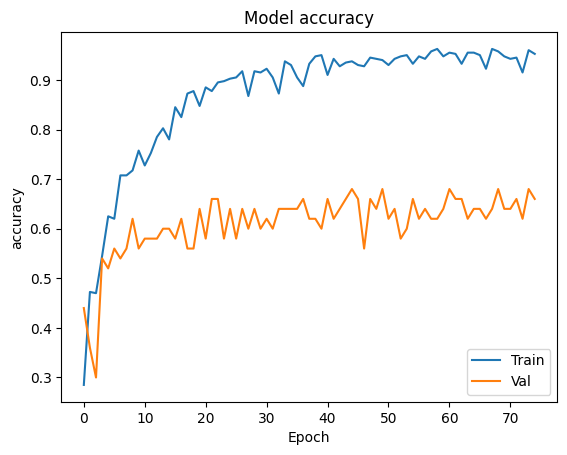

In [ ]:
plt.plot(history_tune.history['accuracy'])
plt.plot(history_tune.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [ ]:
y_test = test_data.labels
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4], dtype=int32)

In [ ]:
y_pred = model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)

2/2 [==============================] - 1s 43ms/step


In [ ]:
class_dirs = os.listdir(test_dir)
print(class_dirs)

['leaf spot', 'whitefly', 'healthy', 'yellowish', 'leaf curl']


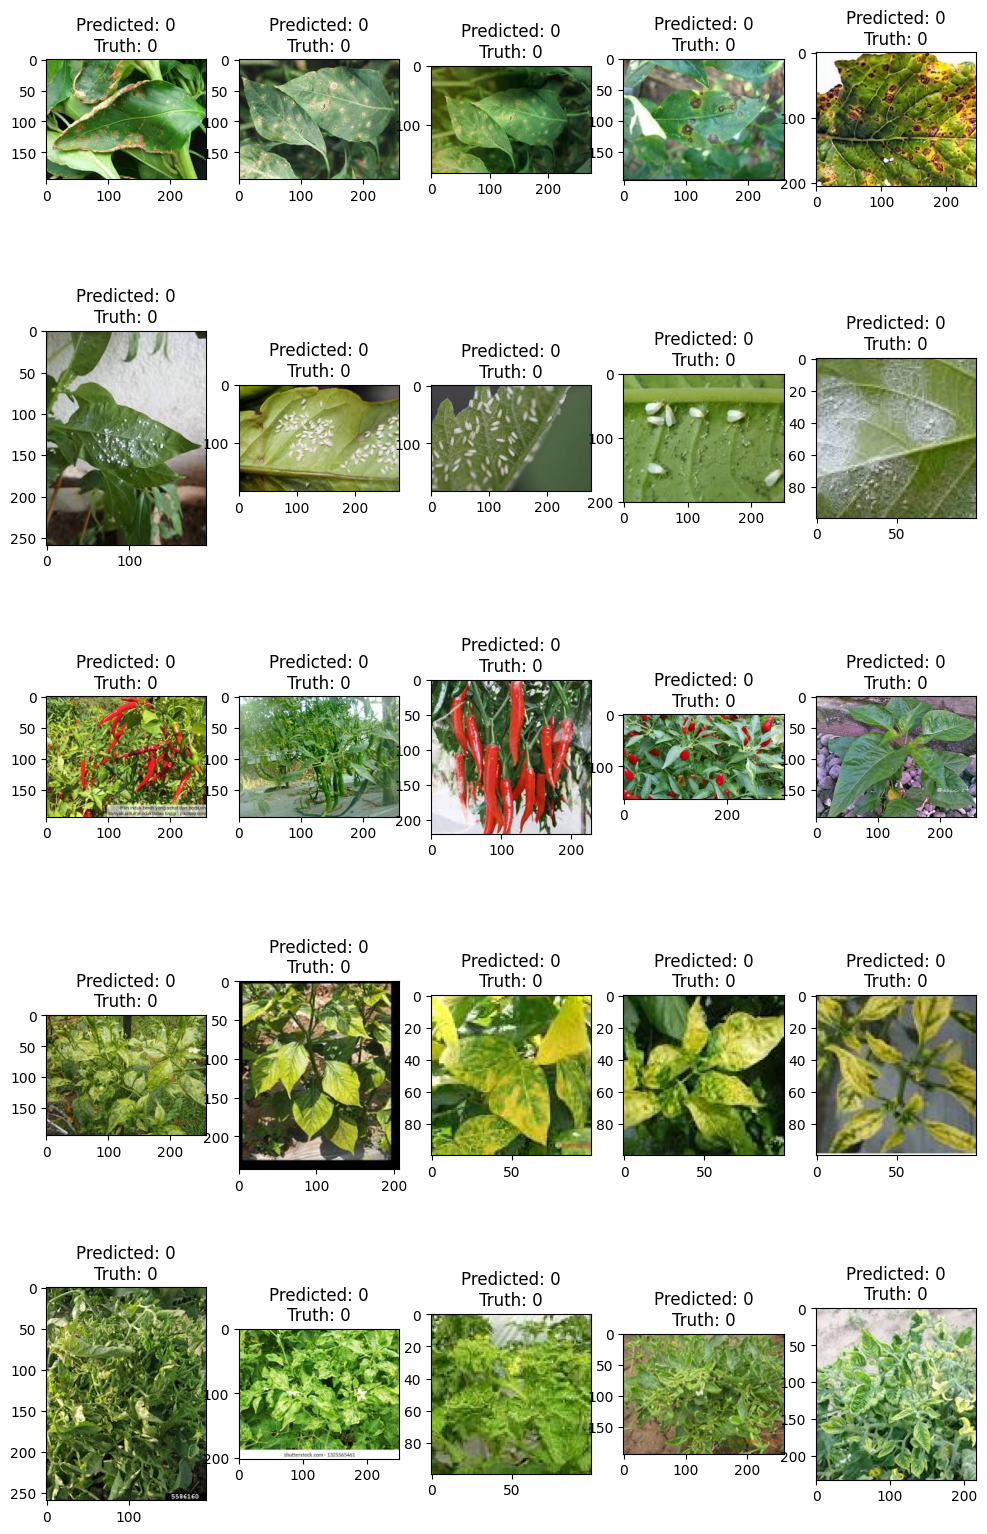

In [ ]:
from PIL import Image

fig, axes = plt.subplots(5, 5, figsize=(12, 20))

index = 0
for i, class_dir in enumerate(class_dirs):
    class_path = os.path.join(test_dir, class_dir)
    image_files = os.listdir(class_path)
    for j, image_file in enumerate(image_files):
        if j < 25:
            img_path = os.path.join(class_path, image_file)
            img = Image.open(img_path).convert("RGB")
            if(index < 5):
                axes[i][index].imshow(img)
                axes[i][index].set_title("Predicted: {}\nTruth: {}".format(y_pred[j], y_test[j]))
                index+=1
            else:
                index = 0

plt.show()

In [ ]:
accuracy_score(y_test, y_pred)

0.9

In [ ]:
confusion_matrix(y_test, y_pred)

array([[10,  0,  0,  0,  0],
       [ 0, 10,  0,  0,  0],
       [ 0,  0, 10,  0,  0],
       [ 0,  0,  1,  9,  0],
       [ 0,  4,  0,  0,  6]])

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.71      1.00      0.83        10
           2       0.91      1.00      0.95        10
           3       1.00      0.90      0.95        10
           4       1.00      0.60      0.75        10

    accuracy                           0.90        50
   macro avg       0.92      0.90      0.90        50
weighted avg       0.92      0.90      0.90        50



In [ ]:
model.save('model.h5')

from google.colab import files
files.download('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#converter = tf.lite.TFLiteConverter.from_keras_model(model)
#tflite_model = converter.convert()

#with open('model.tflite', 'wb') as f:
#    f.write(tflite_model)

In [ ]:
# dot_img_file = 'D:/joki python/model_1.png'
# tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)